In [34]:
import pandas as pd
import numpy as np 
import datetime as dt
import yfinance as yf

from datetime import datetime
import matplotlib.pyplot as plt

In [20]:
#Market Etf Class
class Market:
    
    #accepts excel and csv
    def __init__(self, xlsx, csv):
        self.xlsx = xlsx
        self.csv = csv
        
        #reads in the excel and csv file
        self.tickers_xlsx = pd.read_excel(self.xlsx, header=4)['Ticker'].dropna(how='any')
        self.tickers_csv = pd.read_csv(self.csv, header=9)['Ticker'].dropna(how='any')
        
        #ticker that contains the assets in the etf
        self.tickers = list(set(self.tickers_xlsx) & set(self.tickers_csv))
    
    #accepts years and an etf to return adj close of the etf
    def ticker_history(self, years):
        end = dt.datetime.today()
        start = end - dt.timedelta(days=365*years)
        
        unfil_data = yf.download(self.tickers, start=start, end=end)[['Adj Close', 'Volume']].dropna(axis=0, how='all')
        
        unfil_close = unfil_data['Adj Close']
        unfil_vol = unfil_data['Volume']
        
        close = pd.DataFrame()
        vol = pd.DataFrame()
        
        #filters out stocks with na values
        for ticker in unfil_close.columns:
            if(unfil_close[ticker].isna().sum() > 0):
                unfil_close.drop(columns=ticker, inplace=True)
                unfil_vol.drop(columns=ticker, inplace=True)

        return unfil_close, unfil_vol

In [21]:
#Trading Algorithm that contains all factors
class Trading_Algo:
    
    #creates variables to use in class
    def __init__(self, close, vol):
        self.price = close
        self.volume = vol
        self.tickers = self.price.columns
        self.pct_return = close.pct_change()
        
        #creates dataframes
        self.slopes = pd.DataFrame(index=self.tickers)
        self.vp_slope = pd.DataFrame(index=self.tickers)
        self.factor_agg_df = pd.DataFrame(index=self.tickers)
        
    #returns the trend of each ticker
    def trend(self):
        for i in range(1,21):
            self.slopes[i] = np.polyfit(range(len(self.price[-i - 252: -i])),
                                         self.price[-i - 252: -i], 1)[0]
        return self.slopes.mean(axis=1)
    
    #returns the percent above 52 week low
    def above_low(self):
        min = self.price.rolling(260).min()[-20:].mean()
        return ((self.price - min) / min).mean()
    
    #returns the price oscillation based on z score
    def price_osc(self):
        return ((self.price.rolling(20).mean() - self.price.rolling(260).mean()) / self.price.rolling(260).std())[-20:].mean() 
    
    #return the 
    def returns_39w(self):
         return self.price.pct_change(189)[:20].mean()
        
    def vp_trend(self):
        return (self.pct_return * self.volume).rolling(252).sum()[-20:].mean()
    
    def factor_agg(self):
        self.factor_agg_df['Price Coef'] = self.trend()
        self.factor_agg_df['Perc Low'] = self.above_low()
        self.factor_agg_df['Price Osc'] = self.price_osc()
        self.factor_agg_df['39w Returns'] = self.returns_39w()
        self.factor_agg_df['Volume Price Trend'] = self.vp_trend()
        
        self.factor_agg_df['Z Score'] = (((self.factor_agg_df - self.factor_agg_df.mean()) 
                                          / self.factor_agg_df.std())).sum(axis=1)
        
        return self.factor_agg_df['Z Score'].nlargest(10), self.factor_agg_df['Z Score'].nsmallest(10)

In [22]:
#contains the url to the etf files
xlsx = 'https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx'
csv = 'https://www.blackrock.com/us/individual/products/239726/ishares-core-sp-500-etf/1464253357814.ajax?fileType=csv&fileName=IVV_holdings&dataType=fund'

#calls the Market class sets it equal to etf
etf = Market(xlsx, csv)

In [23]:
#calls history to download 5 year data about the etf 
years = 5
close, vol = etf.ticker_history(years)

[*********************100%***********************]  502 of 502 completed


C:\Users\Stefan\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
#sets up date range to be use for index in output dataframes
end = dt.datetime.today() - dt.timedelta(days=20)
start = end - dt.timedelta(days=365*3.5)
my_dates = pd.date_range(start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), freq='M')

In [25]:
#reorganizes the adj close to monthly returns
month_ret = close[:-20].pct_change().resample('m').sum()

In [26]:
#creates empty dataframe to store short and long baskets
my_port = pd.DataFrame(index=my_dates, columns=close.columns)
short = pd.DataFrame(index=my_dates, columns=close.columns)
long = pd.DataFrame(index=my_dates, columns=close.columns)

TypeError: 'Index' object is not callable

In [27]:
#populates my_port, short port, and long port with '1' on purchased stock
for my_date in my_dates:
    algo = Trading_Algo(close[close.index < my_date], vol[vol.index < my_date]) 
    best, worst = algo.factor_agg()
    for b_index in best.index:
        my_port[b_index].iloc[my_port.index==my_date] = '1'
        long[b_index].iloc[my_port.index==my_date] =  '1'
    for w_index in worst.index:
        my_port[w_index].iloc[my_port.index==my_date] = '-1'
        short[w_index].iloc[my_port.index==my_date] = '-1' 

#fills na values with 0's
my_port.fillna('0', inplace=True)
short.fillna('0', inplace=True)
long.fillna('0', inplace=True)

In [28]:
#multiple each data frame with monthly return to get returns of my_port, short and long baskets
my_returns = pd.DataFrame((month_ret * my_port.astype(int)).mean(axis=1)).dropna()
short_ret = pd.DataFrame((month_ret * short.astype(int)).mean(axis=1)).dropna()
long_ret = pd.DataFrame((month_ret * long.astype(int)).mean(axis=1)).dropna()

#monthly return of etf
etf_ret = pd.DataFrame(month_ret[month_ret.index > start].mean(axis=1))

#difference in monthly return of our port to the etf
port_v_etf = pd.DataFrame(my_returns[0] - etf_ret[0]).dropna()
long_v_etf = pd.DataFrame(long_ret[0] - etf_ret[0]).dropna()
short_v_etf = pd.DataFrame(short_ret[0] - etf_ret[0]).dropna()

In [29]:
#cum returns of my_port, short and long basket
my_returns['cum_ret'] = np.exp(np.log1p(my_returns).cumsum())
short_ret['cum_ret'] = np.exp(np.log1p(short_ret).cumsum())
long_ret['cum_ret'] = np.exp(np.log1p(long_ret).cumsum())

#cum return of etf
etf_ret['cum_ret'] = np.exp(np.log1p(etf_ret.mean(axis=1)).cumsum())

In [30]:
#creates new col for postivie and negative values of return
port_v_etf['colors'] = (port_v_etf[0] > 0)

<AxesSubplot:title={'center':'Difference Between Monthly Returns of Portfolio and ETF'}, xlabel='Dates (Month)', ylabel='Return in Decimal'>

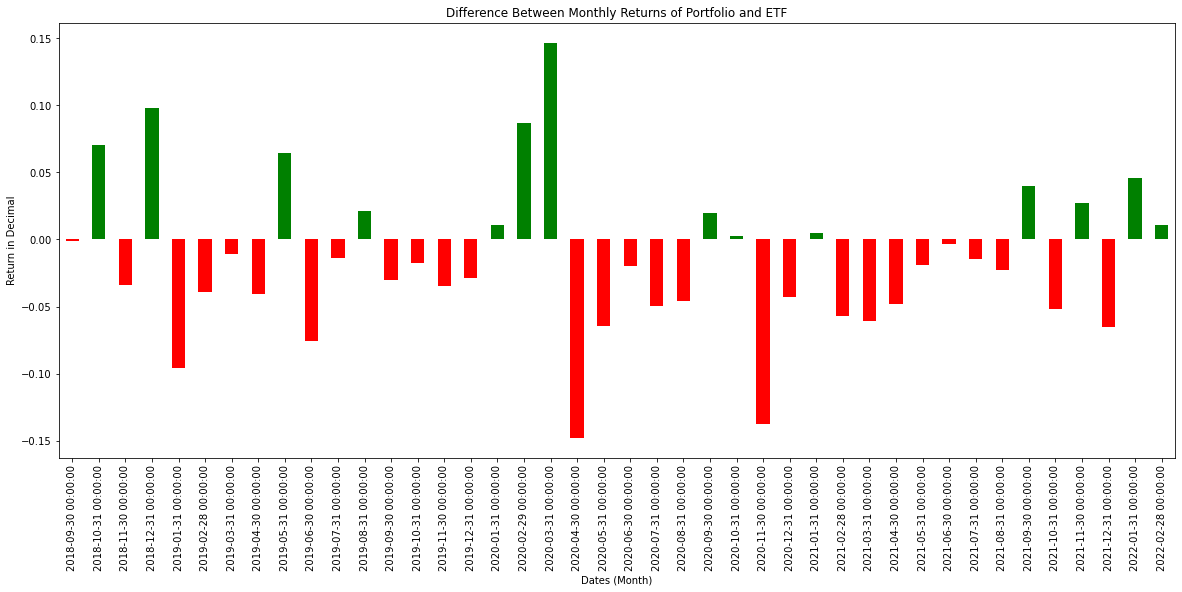

In [31]:
#plots return of the trading algo
port_v_etf[0].plot(kind='bar'
                   , figsize=(20,8)
                   , title='Difference Between Monthly Returns of Portfolio and ETF'
                   , xlabel='Dates (Month)'
                   , ylabel='Return in Decimal'
                   , color=['green' if i == True else 'red' for i in port_v_etf['colors']])

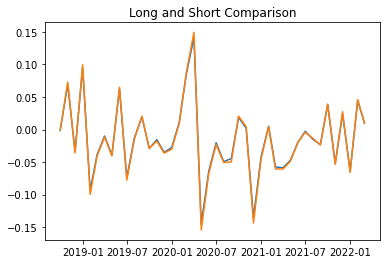

In [32]:
#plots the returns of long and short in comparision with each other
plt.title('Long and Short Comparison')
plt.plot(long_v_etf)
plt.plot(short_v_etf)

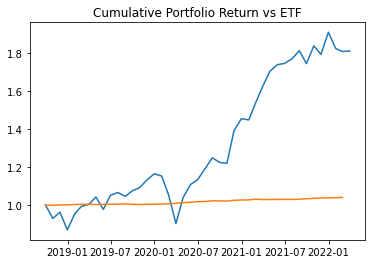

In [33]:
#plots the cumulative portfolio return vs ETF
plt.title('Cumulative Portfolio Return vs ETF')
plt.plot(etf_ret.cum_ret)
plt.plot(my_returns.cum_ret)